In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os
import h5py as hdf
import scipy as scp

plt.rcParams['figure.facecolor'] = 'white'

In [8]:
positions=pd.read_excel('Y:\\Istra Repositories\\ch-gr_exports\\Querzug_overview.xlsx')
positions=positions.iloc[:,1:].set_index('name')

In [9]:
#display(positions[(positions.ok==1.0) | (positions.ok==2.0)])

In [10]:
def get_df_mask(array:np.ndarray)->pd.DataFrame:
    df=pd.DataFrame(array)
    after=df.copy()
    after[after==0.]=np.nan
    after=np.divide(after,after)
    return(after)
def mask_df(df:np.ndarray,mask:np.ndarray)-> pd.DataFrame:
    after=np.multiply(df,mask)
    after=pd.DataFrame(after)
    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    return(after)
def strip_nans(df):
    after=df.copy()
    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    return(after)

In [11]:
sample='MC_A_8yi'
samplelocation='Y:\\Istra Repositories\\ch-gr_exports\\'+sample+'.pickle'
lookup=pd.read_pickle(samplelocation,compression='zip')

In [12]:
def seam_zoom(lookup:pd.DataFrame,vis:str,name:str,positions:pd.DataFrame,width:int):
    """sample=name
    samplelocation='Y:\\Istra Repositories\\ch-gr_exports\\'+sample+'.pickle'
    lookup=pd.read_pickle(samplelocation,compression='zip')"""
    stencil_df=pd.DataFrame(lookup.iloc[10,:][(      'strains',                   'strain_p1')])
    stencil=get_df_mask(stencil_df)
    length_measurement=(mask_df(lookup.iloc[10,:][('coordinates','coordinate_y')],stencil))
    #vis_df_masked=mask_df(lookup.iloc[230,:][vis],stencil)
    #plt.matshow(vis_df_masked)
    #---------------------------------------------
    mean_dict={col:np.nanmean(length_measurement.loc[:,col]) for col in length_measurement.columns}
    measurement_lookup_df=pd.DataFrame(data=mean_dict.values(), index=mean_dict.keys(),columns=['mm'])
    crack_idx=int(positions.loc[name,'crack'])
    seam_idx=int(positions.loc[name,'pos'])
    crack_y_mm=measurement_lookup_df.loc[crack_idx,'mm']
    pos_y_mm=measurement_lookup_df.loc[seam_idx,'mm']
    #display(pos_y_mm)
    left_pos_y_mm=pos_y_mm+(width/2)
    #display(left_pos_y_mm)
    left_pos_y_idx=measurement_lookup_df.iloc[(measurement_lookup_df['mm']-left_pos_y_mm).abs().argsort()[:1]].index.tolist()[0]
    right_pos_y_mm=pos_y_mm-(width/2)
    right_pos_y_idx=measurement_lookup_df.iloc[(measurement_lookup_df['mm']-right_pos_y_mm).abs().argsort()[:1]].index.tolist()[0]

    """fix,[ax1,ax2]=plt.subplots(2,1,figsize=(10,5))
    imb=ax1.matshow(vis_df_masked)
    ax1.axvline(seam_idx,color='red')
    ax1.axvline(crack_idx,color='turquoise')
    ax1.axvline(left_pos_y_idx,color='yellow')
    ax1.axvline(right_pos_y_idx,color='yellow')
    imf=ax2.matshow(mask_df(lookup.iloc[232,:][(      'strains',                   'strain_p1')],stencil).loc[:,left_pos_y_idx:right_pos_y_idx])
    offset=left_pos_y_idx
    ax2.axvline(seam_idx-offset,color='red')
    ax2.axvline(crack_idx-offset,color='turquoise')
    ax2.axvline(left_pos_y_idx-offset,color='yellow')
    ax2.axvline(right_pos_y_idx-offset,color='yellow')
    #ax2.set_xticklabels(np.arange(left_pos_y_idx,right_pos_y_idx,10))
    #display(seam_idx,left_pos_y_idx,right_pos_y_idx)"""
    plt.show()
    return(seam_idx,left_pos_y_idx,right_pos_y_idx,crack_idx)
#idxs=seam_zoom(lookup,('strains','strain_p1'),sample,positions)

In [13]:
def refine_stencil(stencil_df_nonans,left,right):
    stencil_df_nonans.loc[:,:left]=np.nan
    stencil_df_nonans.loc[:,right:]=np.nan
    return(stencil_df_nonans)
#plt.matshow(refine_stencil(stencil_df_nonans,100,150))

In [14]:
def create_full_stencil(lookup,positions,name,width):
    stencil_df_origin=pd.DataFrame(lookup.iloc[10,:][(      'strains',                   'strain_p1')])
    stencil_df_nonans=get_df_mask(stencil_df_origin)
    borders=seam_zoom(lookup,('strains','strain_p1'),name,positions,width)
    full_stencil=refine_stencil(stencil_df_nonans,borders[1],borders[2])
    return(full_stencil)
def apply_full_stencil(lookup,stencil):
    vis=pd.DataFrame(lookup)
    vis=vis.multiply(stencil)
    vis=strip_nans(vis)
    return vis
#plt.matshow(create_full_stencil(lookup,positions,sample,25))

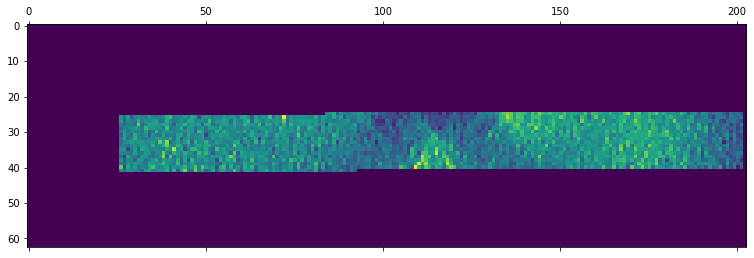

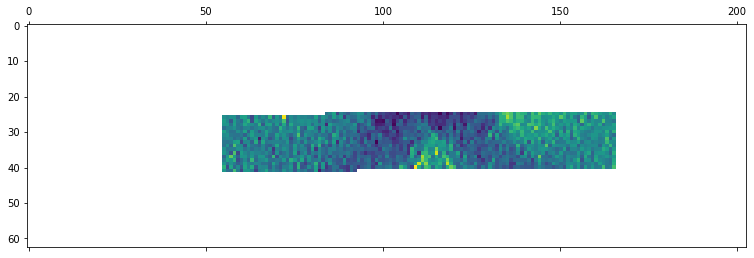

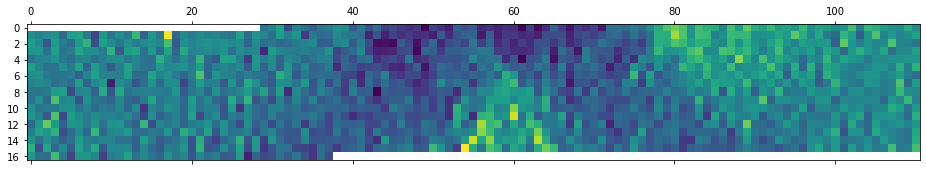

In [21]:
stencil=create_full_stencil(lookup,positions,sample,50)
vis=pd.DataFrame(lookup.iloc[500,:][(      'strains',                   'strain_p1')])
plt.matshow(vis)
plt.matshow(vis.multiply(stencil))
plt.matshow(apply_full_stencil(vis,stencil))

In [22]:
stenciled_lookup=lookup.applymap(lambda x:apply_full_stencil(x,stencil))
display(stenciled_lookup.columns)

MultiIndex([(     'add_data',             'analog_channels'),
            (  'coordinates',                'coordinate_x'),
            (  'coordinates',            'coordinate_x_var'),
            (  'coordinates',                'coordinate_y'),
            (  'coordinates',            'coordinate_y_var'),
            (  'coordinates',                'coordinate_z'),
            (  'coordinates',            'coordinate_z_var'),
            (  'coordinates',           'distance_to_plane'),
            (  'coordinates',          'distance_to_sphere'),
            (  'coordinates',                        'mask'),
            (  'coordinates',             'variance_sphere'),
            ('displacements',          'displacement_total'),
            ('displacements',     'displacement_total_rbmr'),
            ('displacements', 'displacement_total_rbmr_var'),
            ('displacements',      'displacement_total_var'),
            ('displacements',              'displacement_x'),
        

MultiIndex([(     'add_data',             'analog_channels'),
            (  'coordinates',                'coordinate_x'),
            (  'coordinates',            'coordinate_x_var'),
            (  'coordinates',                'coordinate_y'),
            (  'coordinates',            'coordinate_y_var'),
            (  'coordinates',                'coordinate_z'),
            (  'coordinates',            'coordinate_z_var'),
            (  'coordinates',           'distance_to_plane'),
            (  'coordinates',          'distance_to_sphere'),
            (  'coordinates',                        'mask'),
            (  'coordinates',             'variance_sphere'),
            ('displacements',          'displacement_total'),
            ('displacements',     'displacement_total_rbmr'),
            ('displacements', 'displacement_total_rbmr_var'),
            ('displacements',      'displacement_total_var'),
            ('displacements',              'displacement_x'),
        

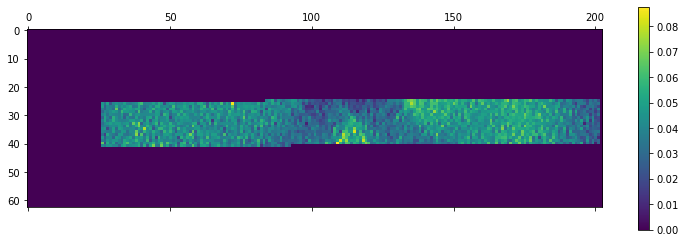

In [23]:
display(stenciled_lookup.columns)
plt.matshow(lookup.iloc[500,:][('strains',                   'strain_p1')])
plt.colorbar()

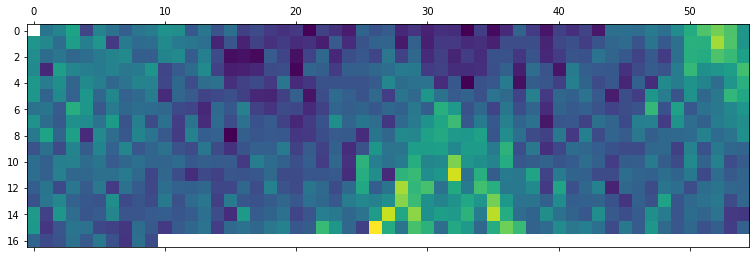

In [18]:
plt.matshow(stenciled_lookup.iloc[500,:][('strains',                   'strain_p1')])

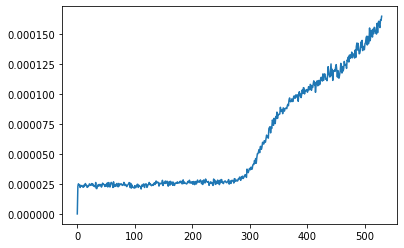

In [19]:
meanvector=stenciled_lookup.loc[:,('strains',                   'strain_p1')].apply(lambda x:np.nanvar(x)).values
plt.plot(meanvector[:530])

,ok,crack,pos
name,,,
MC_A_6xi,1.0,135.0,143.0
MC_A_6xiii,1.0,115.0,119.0
MC_A_6yi,2.0,114.0,117.0
MC_A_6yii,2.0,47.0,50.0
MC_A_6yiii,2.0,100.0,95.0
...,...,...,...
QL_GW_8xi,3.0,NaN,NaN
QL_GW_8xii,1.0,125.0,125.0
QL_GW_8xiii,3.0,NaN,NaN
